<a href="https://colab.research.google.com/github/kiran1465313/satellite_sr/blob/main/01_dataset_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python scikit-image matplotlib

In [ ]:
%cd /content
!git clone https://github.com/XPixelGroup/BasicSR
%cd BasicSR
!pip install -r requirements.txt
!python setup.py develop

In [ ]:
!mkdir -p data/satellite_data/HR
%cd datasets
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip
!find UCMerced_LandUse/Images/ -type f -name '*.tif' -exec mv {} satellite_data/HR/ \;
!rm -r UCMerced_LandUse

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow.image as tfi
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

In [ ]:
#low resolution image converter
def make_lr_from_hr(hr_dir, lr_dir, scale=4):
    os.makedirs(lr_dir, exist_ok=True)
    for filename in os.listdir(hr_dir):
        if filename.lower().endswith(('.tif', '.png', '.jpg', '.jpeg')):
            hr_path = os.path.join(hr_dir, filename)
            img = cv2.imread(hr_path)
            if img is None:
                print(f"⚠️ Skipped unreadable: {filename}")
                continue
            h, w = img.shape[:2]
            lr = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
            lr_path = os.path.join(lr_dir, filename)
            cv2.imwrite(lr_path, lr)
            print(f"✅ Saved: {lr_path}")
%cd /content/BasicSR
make_lr_from_hr('datasets/satellite/HR', 'datasets/satellite/LR', scale=4)

In [ ]:
import os
from PIL import Image
hr_dir = 'data/satellite_data/HR'
lr_dir = 'data/satellite_data/LR'

os.makedirs(lr_dir, exist_ok=True)

scale = 4  # Downscaling factor

for filename in os.listdir(hr_dir):
    if filename.endswith('.tif') or filename.endswith('.png') or filename.endswith('.jpg'):
        hr_path = os.path.join(hr_dir, filename)
        lr_path = os.path.join(lr_dir, filename)

        img = Image.open(hr_path)
        w, h = img.size
        img = img.resize((w // scale, h // scale), Image.BICUBIC)
        img.save(lr_path)

In [ ]:
import os
import cv2

def check_and_clean_mismatched_pairs(hr_dir, lr_dir, scale=4):
    mismatched = []

    for filename in os.listdir(hr_dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
            continue

        hr_path = os.path.join(hr_dir, filename)
        lr_path = os.path.join(lr_dir, filename)

        if not os.path.exists(lr_path):
            print(f"❌ Missing LR image: {filename}")
            mismatched.append((filename, "LR missing"))
            os.remove(hr_path)
            continue

        hr = cv2.imread(hr_path)
        lr = cv2.imread(lr_path)

        if hr is None or lr is None:
            print(f"⚠️ Unreadable image: {filename}")
            mismatched.append((filename, "Unreadable image"))
            if os.path.exists(hr_path): os.remove(hr_path)
            if os.path.exists(lr_path): os.remove(lr_path)
            continue

        h_hr, w_hr = hr.shape[:2]
        h_lr, w_lr = lr.shape[:2]

        if h_hr != h_lr * scale or w_hr != w_lr * scale:
            print(f"❌ Mismatch: {filename} — HR({h_hr},{w_hr}) ≠ LR({h_lr},{w_lr}) × {scale}")
            mismatched.append((filename, "Scale mismatch"))
            os.remove(hr_path)
            os.remove(lr_path)

    print(f"\n✅ Completed check. Removed {len(mismatched)} mismatched pairs.")
    return mismatched

# Example usage:
check_and_clean_mismatched_pairs('datasets/satellite/HR', 'datasets/satellite/LR_fixed', scale=4)



❌ Mismatch: parkinglot09.tif — HR(256,255) ≠ LR(64,63) × 4
❌ Mismatch: baseballdiamond45.tif — HR(256,250) ≠ LR(64,62) × 4
❌ Mismatch: overpass65.tif — HR(247,247) ≠ LR(61,61) × 4
❌ Mismatch: airplane59.tif — HR(253,256) ≠ LR(63,64) × 4
❌ Mismatch: harbor43.tif — HR(256,253) ≠ LR(64,63) × 4
❌ Mismatch: intersection99.tif — HR(256,249) ≠ LR(64,62) × 4
❌ Mismatch: overpass70.tif — HR(247,247) ≠ LR(61,61) × 4
❌ Mismatch: overpass68.tif — HR(247,247) ≠ LR(61,61) × 4
❌ Mismatch: mobilehomepark22.tif — HR(256,253) ≠ LR(64,63) × 4
❌ Mismatch: overpass71.tif — HR(247,247) ≠ LR(61,61) × 4
❌ Mismatch: runway61.tif — HR(256,254) ≠ LR(64,63) × 4
❌ Mismatch: baseballdiamond93.tif — HR(255,256) ≠ LR(63,64) × 4
❌ Mismatch: runway88.tif — HR(254,256) ≠ LR(63,64) × 4
❌ Mismatch: overpass67.tif — HR(247,247) ≠ LR(61,61) × 4
❌ Mismatch: golfcourse07.tif — HR(251,256) ≠ LR(62,64) × 4
❌ Mismatch: buildings96.tif — HR(247,247) ≠ LR(61,61) × 4
❌ Mismatch: storagetanks63.tif — HR(256,254) ≠ LR(64,63) × 4
❌ Mi

[('parkinglot09.tif', 'Scale mismatch'),
 ('baseballdiamond45.tif', 'Scale mismatch'),
 ('overpass65.tif', 'Scale mismatch'),
 ('airplane59.tif', 'Scale mismatch'),
 ('harbor43.tif', 'Scale mismatch'),
 ('intersection99.tif', 'Scale mismatch'),
 ('overpass70.tif', 'Scale mismatch'),
 ('overpass68.tif', 'Scale mismatch'),
 ('mobilehomepark22.tif', 'Scale mismatch'),
 ('overpass71.tif', 'Scale mismatch'),
 ('runway61.tif', 'Scale mismatch'),
 ('baseballdiamond93.tif', 'Scale mismatch'),
 ('runway88.tif', 'Scale mismatch'),
 ('overpass67.tif', 'Scale mismatch'),
 ('golfcourse07.tif', 'Scale mismatch'),
 ('buildings96.tif', 'Scale mismatch'),
 ('storagetanks63.tif', 'Scale mismatch'),
 ('overpass69.tif', 'Scale mismatch'),
 ('overpass59.tif', 'Scale mismatch'),
 ('sparseresidential45.tif', 'Scale mismatch'),
 ('baseballdiamond15.tif', 'Scale mismatch'),
 ('mobilehomepark33.tif', 'Scale mismatch'),
 ('golfcourse04.tif', 'Scale mismatch'),
 ('river83.tif', 'Scale mismatch'),
 ('river30.tif',

In [ ]:
from PIL import Image
%cd /content
!rm -rf BasicSR  # remove wrong clones if any
!git clone https://github.com/XPixelGroup/BasicSR.git
%cd BasicSR
!pip install -r requirements.txt
!pip install -e .  # install BasicSR as a package



In [ ]:
import sys
sys.path.append('/content/BasicSR')

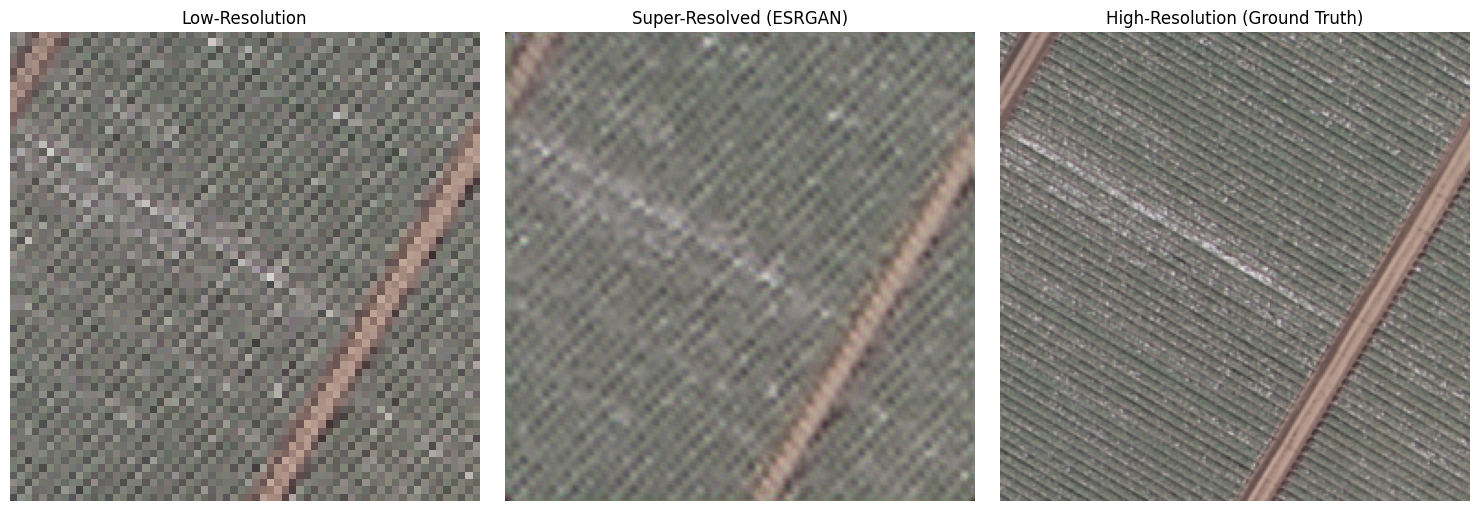

📈 PSNR: 22.09 dB
🔗 SSIM: 0.281


In [26]:
from PIL import Image
import matplotlib.pyplot as plt

# File names
filename = 'agricultural02.tif'

# Paths
lr_img = Image.open(f'datasets/satellite/LR/{filename}')
sr_img = Image.open(f'results/satellite_esrgan_test/visualization/satellite_test/{filename.replace(".tif", "_satellite_esrgan_test.png")}')
hr_img = Image.open(f'datasets/satellite/HR/{filename}')  # Assuming HR images are here

# Plot all three
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Low-Resolution")
plt.imshow(lr_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Super-Resolved (ESRGAN)")
plt.imshow(sr_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("High-Resolution (Ground Truth)")
plt.imshow(hr_img)
plt.axis('off')

plt.tight_layout()
plt.show()

if sr_img.size != hr_img.size:
    hr_img = hr_img.resize(sr_img.size, Image.BICUBIC)

# Convert to numpy arrays and normalize to [0, 1]
sr_np = np.array(sr_img).astype(np.float32) / 255.
hr_np = np.array(hr_img).astype(np.float32) / 255.

# Compute PSNR & SSIM
psnr_val = psnr(hr_np, sr_np, data_range=1.0)
ssim_val = ssim(hr_np, sr_np, channel_axis=2, data_range=1.0)

print(f"📈 PSNR: {psnr_val:.2f} dB")
print(f"🔗 SSIM: {ssim_val:.3f}")

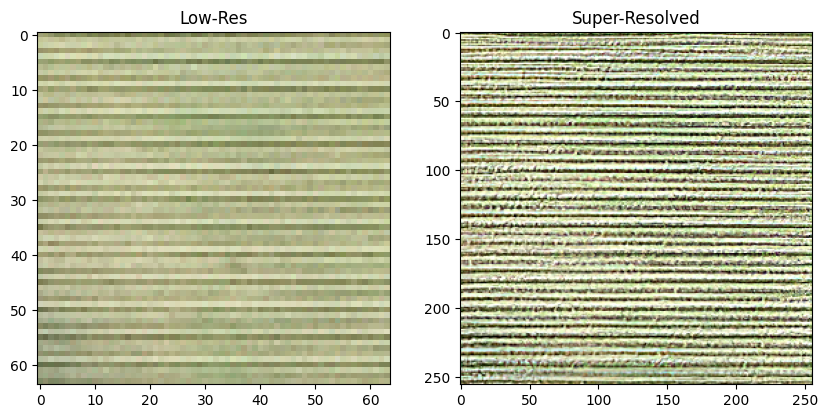

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

lr_img = Image.open('data/satellite_data/LR/agricultural10.png')
sr_img = Image.open('results/satellite_esrgan/agricultural10_ESRGAN.png')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Low-Res")
plt.imshow(lr_img)

plt.subplot(1, 2, 2)
plt.title("Super-Resolved")
plt.imshow(sr_img)
plt.show()

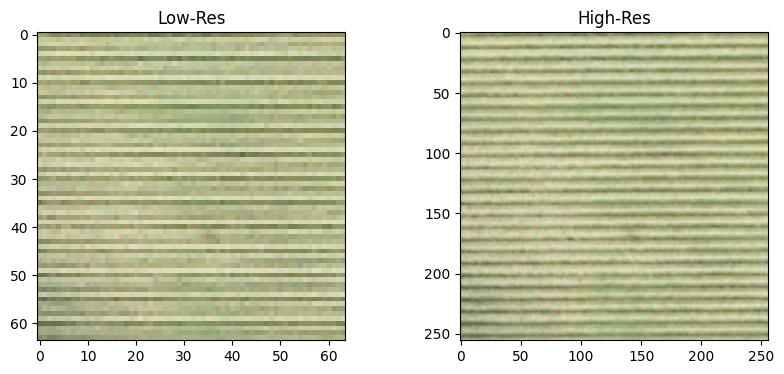

In [ ]:
hr_img = cv2.imread('data/satellite_data/HR/agricultural10.tif')
lr_img = cv2.imread('data/satellite_data/LR/agricultural10.png')


lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Low-Res")
plt.imshow(lr_img)
plt.subplot(1,2,2)
plt.title("High-Res")
plt.imshow(hr_img)
plt.show()

In [ ]:
#Patch extractor

class SatelliteDataset(tf.keras.utils.Sequence):
    def __init__(self, lr_dir, hr_dir, patch_size=48, scale=4, batch_size=8, steps_per_epoch=100):
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.patch_size = patch_size
        self.scale = scale
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch = []
        y_batch = []

        for _ in range(self.batch_size):
            i = random.randint(0, len(self.lr_images) - 1)
            lr_img = cv2.imread(os.path.join(self.lr_dir, self.lr_images[i]))
            hr_img = cv2.imread(os.path.join(self.hr_dir, self.hr_images[i]))

            lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.

            h, w, _ = lr_img.shape
            x = random.randint(0, h - self.patch_size)
            y = random.randint(0, w - self.patch_size)

            lr_patch = lr_img[x:x + self.patch_size, y:y + self.patch_size]
            hr_patch = hr_img[x * self.scale:(x + self.patch_size) * self.scale,
                              y * self.scale:(y + self.patch_size) * self.scale]

            x_batch.append(lr_patch)
            y_batch.append(hr_patch)

        return np.array(x_batch), np.array(y_batch)


In [ ]:
# @title PSNR and SSIM(check)
def compute_psnr(sr_img, hr_img):
    sr_tensor = tf.convert_to_tensor(sr_img, dtype=tf.float32)
    hr_tensor = tf.convert_to_tensor(hr_img, dtype=tf.float32)
    return tf.image.psnr(sr_tensor, hr_tensor, max_val=1.0).numpy()

def compute_ssim(sr_img, hr_img):
    # Ensure images are numpy arrays in range [0, 1]
    sr_img = np.clip(sr_img, 0.0, 1.0)
    hr_img = np.clip(hr_img, 0.0, 1.0)

    return compare_ssim(hr_img, sr_img, multichannel=True, data_range=1.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


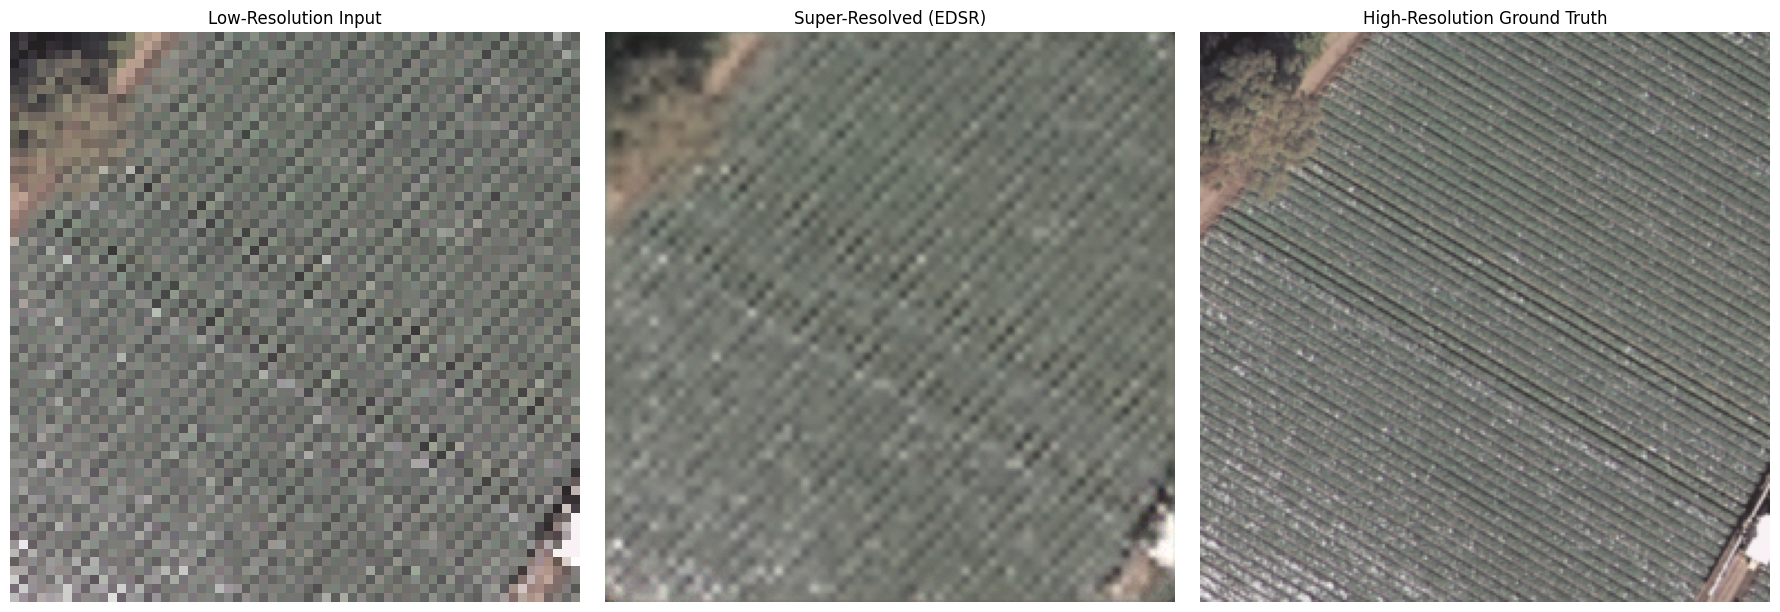

PSNR: 22.62 dB
SSIM: 0.337


In [ ]:
#data exraction
import os
import random
from tensorflow.keras.utils import Sequence

lr_path = 'data/satellite_data/LR/agricultural00.png'
lr_img = cv2.imread(lr_path)
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
lr_img = lr_img.astype(np.float32) / 255.0

lr_input = np.expand_dims(lr_img, axis=0)
hr_path = 'data/satellite_data/HR/agricultural00.tif'
hr_img = cv2.imread(hr_path)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
sr_img = model.predict(lr_input)[0]
# Predict
sr = model.predict(lr_input)[0]
plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
plt.title("Low-Resolution Input")
plt.imshow(lr_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Super-Resolved (EDSR)")
plt.imshow(np.clip(sr_img, 0, 1))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("High-Resolution Ground Truth")
plt.imshow(hr_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Resize HR to match predicted shape (if needed)
hr_img = cv2.resize(hr_img, (sr.shape[1], sr.shape[0]), interpolation=cv2.INTER_CUBIC)

psnr_val = psnr(hr_img, sr, data_range=1.0)
ssim_val = ssim(hr_img, sr, channel_axis=2, data_range=1.0)

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.3f}")

In [ ]:
#Testing
lr = cv2.imread('DIV2K_train_LR_bicubic/X4/0001x4.png')
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
lr = lr.astype(np.float32) / 255.0
lr_input = tf.expand_dims(lr, axis=0)
sr = model(lr_input)
sr = tf.clip_by_value(sr, 0.0, 1.0)
sr_img = tf.squeeze(sr).numpy()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("LR Input")
plt.imshow(lr)
plt.subplot(1, 2, 2)
plt.title("EDSR Output (Trained)")
plt.imshow(sr_img)
plt.show()



NameError: name 'cv2' is not defined

In [ ]:
#Training


%cd /content/BasicSR
!python basicsr/test.py -opt options/test/satellite_esrgan_test.yml --launcher none


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 0.5621
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0641
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0499
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0492
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0484
